# Gravitational Orbits

Defines a GravitationalOrbits class which solves the two-body problem for gravitational attraction between two bodies in Cartesian coordinates

In [1]:
%matplotlib inline

# Import necessary functions
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

To obtain the equations of motion for the two-body problem, we will use the Lagrangian method. Firstly, we need to write the potential and kinetic energies for the two-body gravitational system:

$\begin{align}
T &= \frac{1}{2}m_1 v_{1}^{2} + \frac{1}{2}m_2 v_{2}^{2} = \frac{1}{2} m_1 \left( \dot{x}_{1}^{2} +  \dot{y}_{1}^{2}\right) + \frac{1}{2} m_2 \left( \dot{x}_{2}^{2} +  \dot{y}_{2}^{2}\right) \\
U &= -\frac{G m_1 m_2}{r_{12}}
\end{align}$
  
where $r_{12}$ is the distance between the two masses, given by:

$\begin{align}
r_{12} = \sqrt{\left( x_2 - x_1 \right)^2 + \left( y_2 - y_1 \right)^2}
\end{align}$

The Lagrangian, $\mathcal{L}=T-U$, is:

$\begin{align}
\mathcal{L} = \frac{1}{2} m_1 \left( \dot{x}_{1}^{2} +  \dot{y}_{1}^{2}\right) + \frac{1}{2} m_2 \left( \dot{x}_{2}^{2} +  \dot{y}_{2}^{2}\right) + \frac{G m_1 m_2}{r_{12}}
\end{align}$

The Euler-Lagrange equations are:

$\begin{align}
    \frac{d}{dt} \left( \frac{\partial \mathcal{L}}{\partial \dot{q_i}} \right) - \frac{\partial \mathcal{L}}{\partial q_i} = 0 ~~ \text{for the generalized coordinates} ~~ q_i = \theta_1, \theta_2
\end{align}$

Plugging in the Lagrangian we found above, we get the following equations:

$\begin{align}
   x_1 ~ \text{eq'n:} \quad \ddot{x}_1 &= \frac{G m_2 \left(x_2 - x_1\right)}{r_{12}{}^3} \\
   y_1 ~ \text{eq'n:} \quad \ddot{y}_1 &= \frac{G m_2 \left(y_2 - y_1\right)}{r_{12}{}^3} \\
   x_2 ~ \text{eq'n:} \quad \ddot{x}_2 &= -\frac{G m_1 \left(x_2 - x_1\right)}{r_{12}{}^3} \\
   y_2 ~ \text{eq'n:} \quad \ddot{y}_2 &= -\frac{G m_1 \left(y_2 - y_1\right)}{r_{12}{}^3}
\end{align}$

The function that we will use to solve these equations, solve_ivp, must have first order differential equations as an input. Since the above equations are second order, we must perform a change of variables to obtain a first order system. Define the variables $z_1 \equiv \dot{x_1}$, $z_2 \equiv \dot{y_1}$, $z_3 \equiv \dot{x_2}$, $z_4 \equiv \dot{y_2}$, then we have the following system of first (and zeroth) order differential equations:

$\begin{align}
   z_1 &= x_1 \\
   z_2 &= y_1 \\
   z_3 &= x_2 \\
   z_4 &= y_2 \\
   \dot{z}_1 &= \frac{G m_2 \left(x_2 - x_1\right)}{r_{12}{}^3} \\
   \dot{z}_2 &= \frac{G m_2 \left(y_2 - y_1\right)}{r_{12}{}^3} \\
   \dot{z}_3 &= -\frac{G m_1 \left(x_2 - x_1\right)}{r_{12}{}^3} \\
   \dot{z}_4 &= -\frac{G m_1 \left(y_2 - y_1\right)}{r_{12}{}^3}
\end{align}$

These equations will be implemented into the gravitational orbit solver class.

In [2]:
class GravitationalOrbits():
    """
    This class implements the parameters and Lagrange's equations for
    two particles orbiting under gravitational attraction
    
    Parameters
    ----------
    m1 : float
    m2 : float
    G : float
    
    Methods
    -------
    dt_dt(t, y)
        Returns the right side of the differential equation in vector y,
        given time t and corresponding value of y.
    """
    def __init__(self, m1=1., m2=1., G=1.):
        # Initialize variables within class
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dz_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq:
        [dz/dt d^2z/dt^2]
        
        Parameters
        ----------
        t : float
            time
        z : float
            An 8-component vector with
                    z[0] = x1(t), z[1] = y1(t), z[2] = x1_dot(t), z[3] = y1_dot(t)
                    z[4] = x2(t), z[5] = y2(t), z[6] = x2_dot(t), z[7] = y2_dot(t)
        Returns
        -------
        
        """
        # Define distance between bodies
        r_12 = np.sqrt( (z[4] - z[0])**2 + (z[5] - z[1])**2 )
        return [ \
                z[2], z[3], self.G * self.m2 * (z[4] - z[0]) / r_12**3, self.G * self.m2 * (z[5] - z[1]) / r_12**3, \
                z[6], z[7], -self.G * self.m1 * (z[4] - z[0]) / r_12**3, -self.G * self.m1 * (z[5] - z[1]) / r_12**3, \
               ]
    
    def solve_ode(self, t_pts, z0,
                 abserr=1.0e-8, relerr=1.0e-8):
        # Solve ODE system with solve_ivp
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]),
                             z0, t_eval=t_pts, method='RK23',
                             atol=abserr, rtol=relerr)
        x1, y1, x1_dot, y1_dot, x2, y2, x2_dot, y2_dot = solution.y
        
        return x1, y1, x1_dot, y1_dot, x2, y2, x2_dot, y2_dot
        

We will use the plotting functions $\textbf{plot_y_vs_x}$ and $\textbf{start_stop_indices}$ that were provided to us for previous assignments.

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Make simple orbit plots

Firstly, we define our starting and stopping times for plotting. We also introduce the parameters necessary to fully specify the orbits.

In [5]:
# Labels for individual plot axes
x_vs_y_labels = (r'$x$', r'$y$')

# Common plotting time
t_start = 0.
t_end = 10.
delta_t = 0.05

# Create array of time steps
t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Define orbit parameters
m1 = 1.
m2 = 10.
G = 1.

# Initialize the orbits using the class
go1 = GravitationalOrbits(m1=m1, m2=m2, G=G)

Plot the orbit for one set of initial conditions

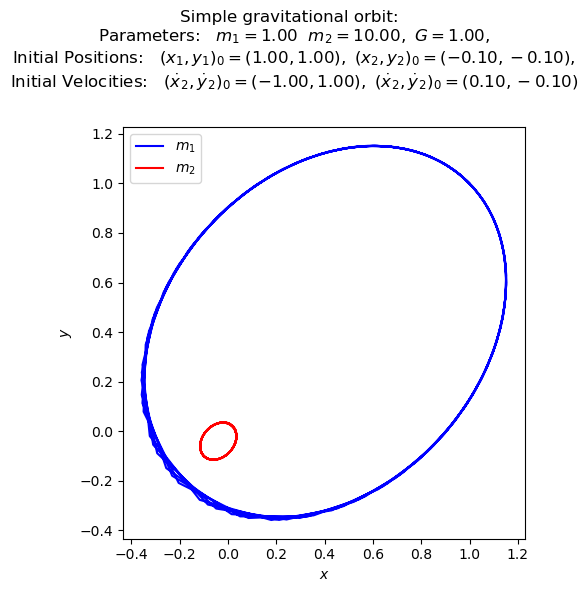

In [6]:
# Initial conditions
x1_0, y1_0 = 1., 1.
x1_dot_0, y1_dot_0 = -1.0, 1.0

x2_0, y2_0 = -(m1/m2) * x1_0, -(m1/m2) * y1_0
x2_dot_0, y2_dot_0 = -(m1/m2) * x1_dot_0, -(m1/m2) * y1_dot_0
# Note: x2_dot_0 and y2_dot_0 are defined in this way to ensure that the CM has zero momentum

# Put initial conditions into a single vector for input into the ODE solver function
z0 = [x1_0, y1_0, x1_dot_0, y1_dot_0, x2_0, y2_0, x2_dot_0, y2_dot_0]

# Solve the system 
x1, y1, x1_dot, y1_dot, x2, y2, x2_dot, y2_dot = go1.solve_ode(t_pts, z0)

# Create the figure and add text
fig = plt.figure(figsize=(5,5))
overall_title = 'Simple gravitational orbit:  ' + \
                '\n' + \
                'Parameters:  ' + \
                rf' $m_1 = {m1:.2f}$' + \
                rf'  $m_2 = {m2:.2f},$' + \
                rf' $G = {G:.2f},$' + \
                '\n' + \
                'Initial Positions:  ' + \
                rf' $(x_1, y_1)_0 = ({x1_0:.2f}, {y1_0:.2f}), $' + \
                rf' $(x_2, y_2)_0 = ({x2_0:.2f}, {y2_0:.2f}), $' + \
                '\n' + \
                'Initial Velocities:  ' + \
                rf' $(\dotx_2, \doty_2)_0 = ({x1_dot_0:.2f}, {y1_dot_0:.2f}), $' + \
                rf' $(\dotx_2, \doty_2)_0 = ({x2_dot_0:.2f}, {y2_dot_0:.2f})$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Create the axes
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=r'$m_1$', 
            ax=ax_a)     
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=r'$m_2$', 
            ax=ax_a)    

# Adjust layout and save figure
fig.tight_layout(rect=[0, 0, 1, 1.2])
fig.savefig('gravitational_orbit_1.png', bbox_inches='tight')

In [7]:
# Import animation functions
from matplotlib import animation, rc
from IPython.display import HTML

In [8]:
%%capture

# Define size of the animation window
x_min = -3.
x_max = 3.
y_min = -3.
y_max = 3.

fig_anim = plt.figure(figsize=(5,5), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

# This next section of code initializes the data for the various objects that we will animate

# Define size, shape, and color of pendulum bob
body1_anim, = ax_anim.plot(x1, y1, 'o', markersize=2, color='blue')
body2_anim, = ax_anim.plot(x2, y2, 'o', markersize=2, color='blue')


fig_anim.tight_layout()

In [9]:
def animate_orbits(i):
    """
    This is the function called by FuncAnimation to create each frame,
    numbered by i.  So each i corresponds to a point in the t_pts
    array, with index i.
    """
    
    #Update the data of each object we created in the previous cell over all time steps in t_pts
    
    body1_anim.set_data(x1, y1)
    body2_anim.set_data(x2, y2)
             
    return (body1_anim, body2_anim)

In [10]:
frame_interval = 20.  # time between frames
frame_number = 1001    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_orbits, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)


In [ ]:
HTML(anim.to_jshtml())  
